# Displaying Molecular Formulas in Tables and Graphs

Here's how to display formatted molecular formulas in tables and graphs. In addition to formatted molecular formulas, these techniques should work for any Markdown or LaTeX.

In the last blog post, we generated molecular formulas from SMILES strings or RDKit molecules. Once we have those molecular formulas, formatted as Markdown or LaTeX, we might want to display them in tables or graphs.

One of the uses of a molecular formula is for [elemental analysis](https://en.wikipedia.org/wiki/Elemental_analysis#CHNX_analysis) because it determines the mass percentage of each element in a compound. So all we need to know for elemental analysis is the count of each element in the molecule, not the arrangement of atoms.

In [1]:
%%capture
%!pip install rdkit
%!pip install black[jupyter]
%!pip install polars
%!pip install pyarrow

In [2]:
# Mount Google Drive so can format code in this notebook using black
# from google.colab import drive

# drive.mount("/content/drive")

In [3]:
# Format code using black
# procedure at https://stackoverflow.com/questions/63076002/code-formatter-like-nb-black-for-google-colab#71001241
# !black "/content/drive/MyDrive/Colab Notebooks/Molecular Formula Generation.ipynb"

In [4]:
from collections import defaultdict
from IPython.display import display, Markdown

from rdkit import Chem
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Molecular formula generation code from previous blog post

Refer to the [previous post]({% post_url 2023-10-20-Molecular-Formula-Generation %}) for more information on these functions.

In [5]:
def composition(
    molecule: Chem.Mol,
    isotopes: bool = False,
) -> defaultdict:
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and isotopes if requested.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :param isotopes: Whether to include the isotope of each atom
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if not molecule:
        return

    # Add hydrogen atoms--RDKit excludes them by default
    molecule = Chem.AddHs(molecule)
    comp = defaultdict(lambda: 0)

    # Get atom counts
    for atom in molecule.GetAtoms():
        element_symbol = atom.GetSymbol()
        # If isotopes not requested, simply count the number of atoms of each element
        if not isotopes:
            comp[element_symbol] += 1
        # If isotopes requested, count the number of each isotope of each element
        else:
            isotope = atom.GetIsotope()
            try:
                comp[element_symbol][isotope] += 1
            except:
                comp[element_symbol] = defaultdict(lambda: 0)
                comp[element_symbol][isotope] += 1
    return comp

In [6]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [7]:
def markdown_formula(latex: str) -> str:
    latex_markdown = r"$\mathrm{ %s}$" % (latex.strip("$"))
    return latex_markdown

In [12]:
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :returns: A set.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [15]:
def dict_list_to_markdown_table(data, number_rows=False):
    """
    Convert a list of dictionaries into a Markdown table.

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.
        include_row_numbers (bool): Whether to include a row number column.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

In [18]:
def markdown_formula(latex: str) -> str:
    return r"$\mathrm{ %s}$" % (latex.strip("$"))

## Elemental analysis code to calculate weight percent by element

We define an `elemental_analysis_mol` class to hold the RDKit molecule, formulas, total mass, and the weight percent of each atom in the molecule.

In [13]:
class elemental_analysis_mol():
    def __init__(self, mol):
        self.mol = mol

        # Create dictionary of element:absolute mass
        element_abs_dict = defaultdict()
        for atom in mol.GetAtoms():
            try:
                element_abs_dict[atom.GetSymbol()] += atom.GetMass()
            except:
                element_abs_dict[atom.GetSymbol()] = atom.GetMass()

        formulas = mol_to_formatted_formula(self.mol)
        self.formula_markdown = formulas.get("markdown")
        self.formula_latex = formulas.get("latex")
        self.total_mass = sum(element_abs_dict.values())

        # Create dictionary of element:relative (to the molecule) mass
        self.element_rel_dict = defaultdict()
        for element, mass in element_abs_dict.items():
            self.element_rel_dict[element] = mass/self.total_mass
    def update(self, mol):
        """Define an update method so the elemental_analysis_mol can remain as the same object if updated"""
        self.__init__(mol)
    def get_mass_frac(self, element):
        return self.element_rel_dict.get(element, 0)

The set of molecules we'll consider contain carbon, hydrogen, and sometimes oxygen.

In [28]:
smls = ["CO", "CCO", "CCCO", "C"]

We'll build a Polars dataframe with the SMILES, `elemental_analysis_mol`, and formulas.

In [29]:
df = df = pl.DataFrame({"sml": smls})
df = df.with_columns(
    [
        pl.col("sml").map_elements(lambda sml: Chem.AddHs(Chem.MolFromSmiles(sml))).alias("mol"),
    ]
)
df = df.with_columns(
    [
        pl.col("mol").map_elements(lambda mol: elemental_analysis_mol(mol)).alias("elemental_analysis_mol"),
    ]
)
df = df.with_columns(
    [
        pl.col("elemental_analysis_mol").map_elements(lambda x: x.formula_markdown).alias("formula_markdown"),
        pl.col("elemental_analysis_mol").map_elements(lambda x: markdown_formula(x.formula_latex)).alias("formula_latex"),
    ]
)

Now we need to add the elemental weight percents. We need to include values for each element in any molecule, so we create a set of all the elements in any molecule.

In [53]:
# Create set of elements in all molecules
element_set_mols = set()

for mol in df["mol"]:
    element_set_mols.update(element_set(mol))
element_set_mols

for element in element_set_mols:
    df = df.with_columns(
    [
        pl.col("elemental_analysis_mol").map_elements(lambda x: round(x.get_mass_frac(element) * 100, 4)).alias(f"wt %{element}"),
    ]
)
df

sml,mol,elemental_analysis_mol,formula_markdown,formula_latex,wt %O,wt %C,wt %H
str,object,object,str,str,f64,f64,f64
"""CO""",<rdkit.Chem.rdchem.Mol object at 0x173e3af10>,<__main__.elemental_analysis_mol object at 0x10a5a7450>,"""CH<sub>4</sub>…","""$\mathrm{ CH_{…",49.9313,37.4852,12.5835
"""CCO""",<rdkit.Chem.rdchem.Mol object at 0x173e3af80>,<__main__.elemental_analysis_mol object at 0x173d5bdd0>,"""C<sub>2</sub>H…","""$\mathrm{ C_{ …",34.7283,52.1435,13.1281
"""CCCO""",<rdkit.Chem.rdchem.Mol object at 0x173e3ac00>,<__main__.elemental_analysis_mol object at 0x173d72250>,"""C<sub>3</sub>H…","""$\mathrm{ C_{ …",26.6224,59.9591,13.4185
"""C""",<rdkit.Chem.rdchem.Mol object at 0x173e3aff0>,<__main__.elemental_analysis_mol object at 0x173d71750>,"""CH<sub>4</sub>…","""$\mathrm{ CH_{…",0.0,74.8675,25.1325


## Displaying molecular formulas in a table

To display molecular formulas in a table, we'll use the Markdown formulas. We select only human-readable columns to display.

In [54]:
df_display = df.select([
    col for col in df.columns
    if col.startswith("wt") or col in ["sml", "formula_markdown"]
])
table = dict_list_to_markdown_table(
    df_display.rows(named=True),
    number_rows=True)
display(Markdown(table))

| # | sml | formula_markdown | wt %O | wt %C | wt %H |
| --- | --- | --- | --- | --- | --- |
| 1 | CO | CH<sub>4</sub>O | 49.9313 | 37.4852 | 12.5835 |
| 2 | CCO | C<sub>2</sub>H<sub>6</sub>O | 34.7283 | 52.1435 | 13.1281 |
| 3 | CCCO | C<sub>3</sub>H<sub>8</sub>O | 26.6224 | 59.9591 | 13.4185 |
| 4 | C | CH<sub>4</sub> | 0.0 | 74.8675 | 25.1325 |


This table tells us what weight percentages to expect for an elemental analysis of these compounds.

## Displaying molecular formulas in a graph

It's easier to create a graph from a Pandas dataframe, so we extract the data from Polars as lists and read them into Pandas. We're going to use LaTeX to display the molecular formulas in the graph, so that's the formula column we bring over.

In [55]:
sml_list = df["sml"].to_list()
formula_latex_list = df["formula_latex"].to_list()
wt_O_list = df["wt %O"].to_list()
wt_H_list = df["wt %H"].to_list()
wt_C_list = df["wt %C"].to_list()


In [56]:
df_pandas_all = pd.DataFrame({
    'sml': sml_list,
    'Molecule': formula_latex_list,
    'O': wt_O_list,
    'H': wt_H_list,
    'C': wt_C_list,
})
df_pandas_all

,sml,Molecule,O,H,C
0,CO,$\mathrm{ CH_{ 4}O}$,49.9313,12.5835,37.4852
1,CCO,$\mathrm{ C_{ 2}H_{ 6}O}$,34.7283,13.1281,52.1435
2,CCCO,$\mathrm{ C_{ 3}H_{ 8}O}$,26.6224,13.4185,59.9591
3,C,$\mathrm{ CH_{ 4}}$,0.0000,25.1325,74.8675


Now, to plot the data, we need to "melt" or "explode" the data by making a row out of each element's weight percent column.

In [59]:
# Melt the DataFrame for Seaborn
df_melted = df_pandas_all.melt(id_vars=['Molecule', 'sml'], var_name='Element', value_name='weight %')
df_melted

,Molecule,sml,Element,weight %
0,$\mathrm{ CH_{ 4}O}$,CO,O,49.9313
1,$\mathrm{ C_{ 2}H_{ 6}O}$,CCO,O,34.7283
2,$\mathrm{ C_{ 3}H_{ 8}O}$,CCCO,O,26.6224
3,$\mathrm{ CH_{ 4}}$,C,O,0.0000
4,$\mathrm{ CH_{ 4}O}$,CO,H,12.5835
5,$\mathrm{ C_{ 2}H_{ 6}O}$,CCO,H,13.1281
6,$\mathrm{ C_{ 3}H_{ 8}O}$,CCCO,H,13.4185
7,$\mathrm{ CH_{ 4}}$,C,H,25.1325
8,$\mathrm{ CH_{ 4}O}$,CO,C,37.4852
9,$\mathrm{ C_{ 2}H_{ 6}O}$,CCO,C,52.1435


Now we're ready to create the plot. We use 

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

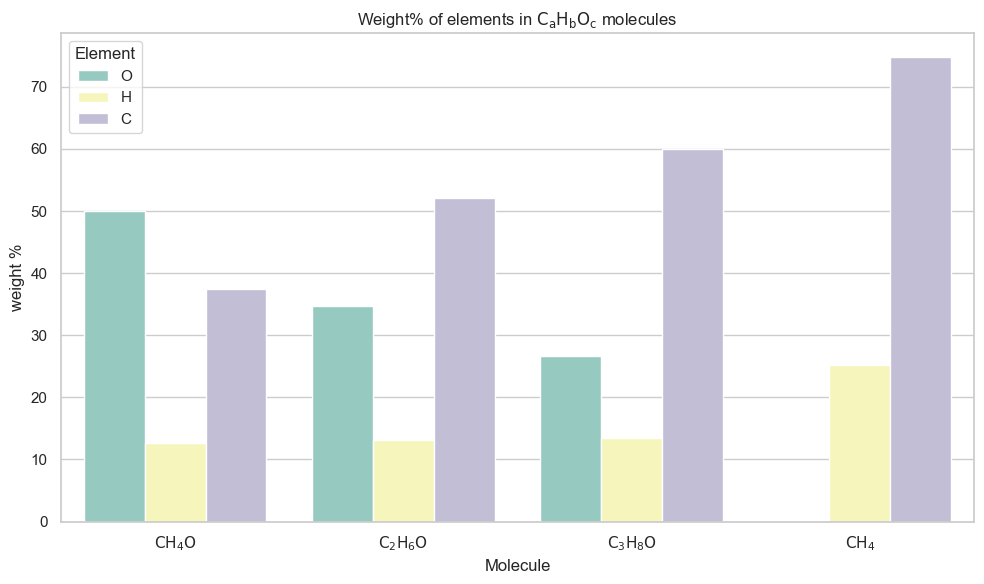

In [63]:
# Create the column plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use hue to group by elements (O, H, C)
sns.barplot(x="Molecule", y="weight %", hue="Element", data=df_melted, palette="Set3")

# Use LaTeX to include a formula in the plot title
class_of_molecules = "$\mathrm{ C_{ a}H_{ b}O_{ c}}$"
plt.title("Weight% of elements in " + class_of_molecules + " molecules")

# xticks gets the x values from the Molecule column, which are LaTeX strings of the molecular formulas
plt.xticks()

plt.legend(title="Element")
plt.tight_layout()
plt.show()

This graph displays the weight percentages we expect for an elemental analysis of these compounds. For example, considering the C1-C3 alcohols (methanol, ethanol, propanol), we can tell that the weight percent of carbon increases with carbon chain length.

## Conclusion

This was an example of how to display molecular formulas in tables and graphs for a straightforward calculation. In the next blog posts, we'll apply these techniques to a more involved cheminformatics problem.